In [1]:
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Reader
from sklearn.preprocessing import StandardScaler
from surprise import Dataset
from surprise import accuracy
from surprise import SVD, SVDpp, CoClustering, NormalPredictor, BaselineOnly
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

El objetivo del proyecto es realizar un sistema de recomendación que permita sugerir juegos en la plataforma Steam.

# 0. Importación y preparación de datos

Lo primero que se realiza es importar los dataset. Uno contiene los datos de la interacción de cada usuario con cierto juego mientras que el otro contiene datos de los juegos. 

**Dado el tamaño del dataset de reseñas solo se van a importar 1 de cada 10 filas**:

In [15]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [16]:
contador = 0
data_reviews = []
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)

In [17]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [18]:
data_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [19]:
data_games.head(5)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Se procede a unir los dos datasets en uno solo con toda la información. El proceso de unión es realizado a través de la columna product id del dataset de reseñas y la columna id del dataset de juegos.

In [20]:
data = pd.merge(left=data_reviews, right=data_games, left_on='product_id', right_on='id')

In [21]:
data.head(5)

,username,hours,products,product_id,page_order,date,text,early_access_x,page,user_id,...,tags,discount_price,reviews_url,specs,price,early_access_y,id,developer,sentiment,metascore
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,...,"[Action, Adventure, Indie, Simulation]",NaN,http://steamcommunity.com/app/725280/reviews/?...,"[Single-player, Steam Trading Cards]",2.99,False,725280,Vyacheslav Shilikhin,Positive,NaN
1,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,...,"[Action, Adventure, Indie, Simulation]",NaN,http://steamcommunity.com/app/725280/reviews/?...,"[Single-player, Steam Trading Cards]",2.99,False,725280,Vyacheslav Shilikhin,Positive,NaN
2,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,...,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,NaN
3,dll3z,0.4,314.0,328100,5,2017-03-07,do not buy this game,False,2,NaN,...,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,NaN
4,Nyazicat,2.2,1224.0,328100,1,2017-01-09,For some reason I entirely derped out and boug...,False,3,NaN,...,"[Adventure, RPG, Indie, Puzzle, Match 3]",NaN,http://steamcommunity.com/app/328100/reviews/?...,[Single-player],14.99,False,328100,Ino-Co Plus,Mixed,NaN


# 1. Analísis Exploratorio de Datos

El tamaño del dataset es el siguiente:

In [30]:
data.shape

(779951, 7)

Es decir que **el dataset tiene 779.951 filas (o "reseñas") y 28 columnas**, siendo las columnas las siguientes:

In [31]:
data.columns.values

array(['username', 'app_name', 'hours', 'price', 'publisher', 'developer',
       'genres'], dtype=object)

Lo primero que se va a realizar es eliminar las columnas dado que permite hacer el dataset más manejable eliminando información que no resulta relevante. Las columnas que se van a seleccionando del dataset son las siguientes:
1. **Username**: para identificar cada usuario.
2. **Hours**: informa la cantidad de horas que cada usuario jugó el juego.
3. **Publisher**: la compañía que comercializó el juego.
4. **Genres**: los géneros que aplican a cada juego.
5. **Price**: el precio del juego.
6. **Developer**: desarrollador del juego (puede ser distinto al que lo comercializa).
7. **app_name**: Nombre del juego.

El dataset es el siguiente (con las mismas filas que el anterior pero solo 7 columnas):

In [24]:
data = data[["username", "app_name", "hours", "price", "publisher", "developer", "genres"]]
data.head(5)

,username,app_name,hours,price,publisher,developer,genres
0,Chaos Syren,Psi Project,0.1,2.99,Vyacheslav Shilikhin,Vyacheslav Shilikhin,"[Action, Adventure, Indie, Simulation]"
1,freakfantom,Psi Project,0.1,2.99,Vyacheslav Shilikhin,Vyacheslav Shilikhin,"[Action, Adventure, Indie, Simulation]"
2,Ariman1,Gunspell - Steam Edition,13.2,14.99,KISS ltd,Ino-Co Plus,"[Adventure, Indie, RPG]"
3,dll3z,Gunspell - Steam Edition,0.4,14.99,KISS ltd,Ino-Co Plus,"[Adventure, Indie, RPG]"
4,Nyazicat,Gunspell - Steam Edition,2.2,14.99,KISS ltd,Ino-Co Plus,"[Adventure, Indie, RPG]"


Para facilitar el proceso se va a guardar una versión del dataset para luego importarla y trabajar sobre la misma.

In [ ]:
data.to_csv ("data_steam.csv", index = False)

In [2]:
data = pd.read_csv("data_steam.csv")

Los tipos de variables son los siguientes:

In [3]:
data.dtypes

username      object
app_name      object
hours        float64
price         object
publisher     object
developer     object
genres        object
dtype: object

La **variable precio asume un valor de objeto cuando se requiere que la misma sea float**. Antes de realizar el cambio de tipo se analiza cuales son los valores que asume la variable precio:

In [4]:
data["price"].unique().tolist()

['2.99',
 '14.99',
 '9.99',
 '19.99',
 '4.99',
 nan,
 '0.99',
 '5.99',
 '11.99',
 '7.99',
 '3.99',
 'Free to Play',
 '29.99',
 '1.99',
 '18.99',
 '8.99',
 '39.99',
 '13.99',
 '6.99',
 'Free To Play',
 'Free',
 '20.0',
 '59.99',
 '12.99',
 '15.99',
 '24.99',
 'Play for Free!',
 '1.87',
 '16.99',
 '49.99',
 '17.99',
 '44.99',
 '10.99',
 '5.65',
 '99.99',
 '34.99',
 '64.99',
 '0.5',
 '0.89',
 '119.99',
 '0.49',
 '10.96',
 '1.29',
 '79.99',
 '189.96',
 '74.99',
 '15.0',
 '2.97',
 '4.0',
 '11.15',
 'Play WARMACHINE: Tactics Demo',
 '4.68',
 '12.89',
 'Play the Demo',
 '54.99',
 '31.99',
 'Free Mod',
 '49.0',
 '13.98',
 '44.98',
 '74.76',
 '32.99',
 '4.49',
 '189.0',
 '0.98',
 '202.76',
 '61.99',
 '13.37',
 '3.0',
 '69.99',
 'Free to Use',
 '1.59',
 '87.94',
 '149.99',
 'Install Now',
 '7.49',
 '16.06',
 '3.49',
 '19.98',
 'Free to Try',
 '3.33',
 '23.96',
 '21.99',
 '399.99',
 '6.66',
 '1.95',
 '19.95',
 'Starting at $449.00',
 '2.49',
 '139.92',
 '199.0',
 '23.99',
 '12.0',
 '1.0',
 '9.95'

Hay varios valores en la lista que son equivalentes a un precio de 0 motivo por el cual se realiza el cambio de un string al valor 0:

In [5]:
lista = ['Free to Play', 'Free To Play', 'Play for Free!', 'Play WARMACHINE: Tactics Demo', "Free",
         'Play the Demo', 'Free Mod', 'Free to Use', 'Install Now', 'Free to Try', 'Third-party',
        'Free Movie', 'Free HITMAN™ Holiday Pack']
data["price"] = data["price"].replace(lista, 0)
data["price"] = data["price"].replace(["Starting at $449.00"], 499)

Posteriormente se realiza el cambio del tipo de variable:

In [6]:
data["price"] = pd.to_numeric(data["price"])

Los valores faltantes en cada columna son los siguientes:

In [7]:
print(data.isnull().sum())

username       18
app_name        0
hours        2637
price        6673
publisher    9656
developer    5788
genres       4023
dtype: int64


Es decir que los valores faltantes son escasos dada la cantidad de reseñas que contiene el dataset motivo por el cual se determina eliminar estas filas.

In [8]:
data = data.dropna()
data.shape

(760492, 7)

**Luego de eliminar las filas con valores faltantes se tiene un dataset con 760.492 filas.**

Los 20 juegos más populares en términos de reseñas fueron los siguientes:

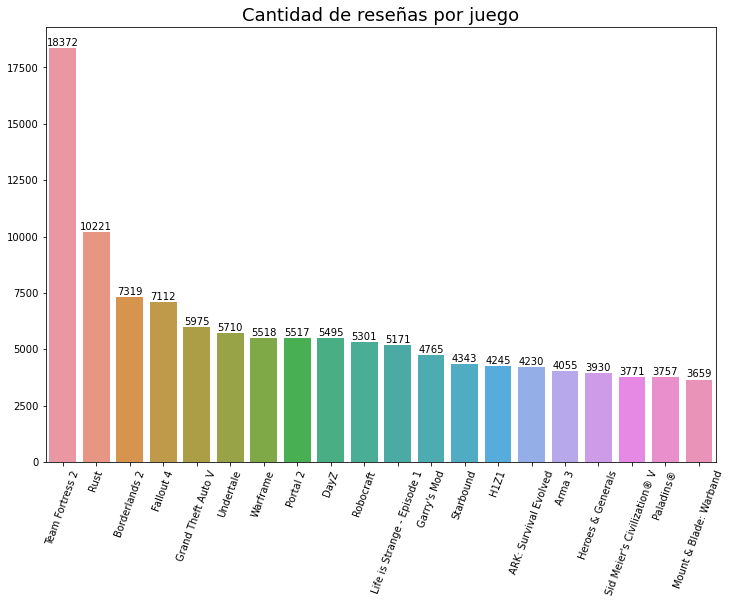

In [12]:
plt.figure(figsize=(12,8))
grafico1 = sns.countplot(x = "app_name", data = data, order = data["app_name"].value_counts().iloc[:20].index)
plt.title("Cantidad de reseñas por juego", fontsize=18)
plt.xticks(rotation=70)
plt.xlabel("")
plt.ylabel("")

conteo = list(data.app_name.value_counts())
for rect, label in zip(grafico1.patches, conteo):
    height = rect.get_height()
    grafico1.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

De acuerdo al gráfico anterior **el juego más popular es Team Fortress 2, superando ampliamente a Rust y Borderlands 2**.

Respecto a las compañías comercializadoras, las más exitosas (en términos de reseñas) son las siguientes:

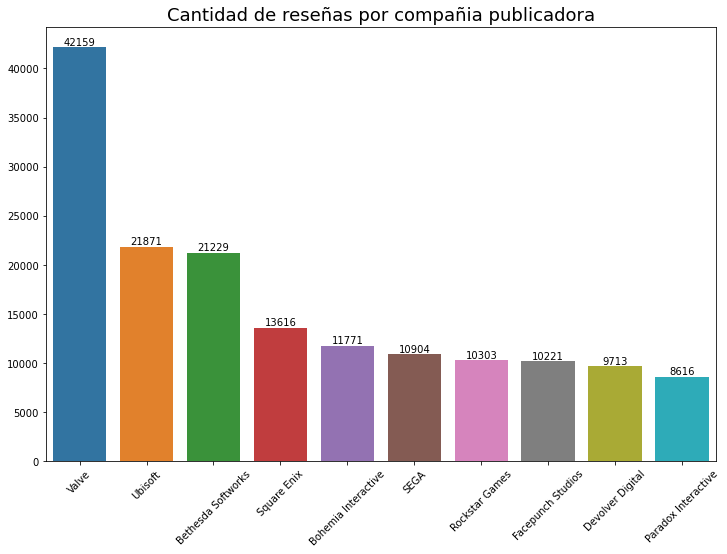

In [13]:
plt.figure(figsize=(12,8))
grafico1 = sns.countplot(x = "publisher", data = data, order = data["publisher"].value_counts().iloc[:10].index)
plt.title("Cantidad de reseñas por compañia publicadora", fontsize=18)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("")

conteo = list(data.publisher.value_counts())
for rect, label in zip(grafico1.patches, conteo):
    height = rect.get_height()
    grafico1.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

**Valve es la compañía con mayor cantidad de reseñas** lo que no debería sorpender dado que Steam pertenece a Valve y que varios de los juegos que figuran entre los más populares son comercializados (algunos de ellos desarrollados) por esta firma entre ellos Team Fortress 2 y Portal 2. Ubisoft y Bethesda completan el podio.

Mientras que los desarrolladores más populares son los siguientes:

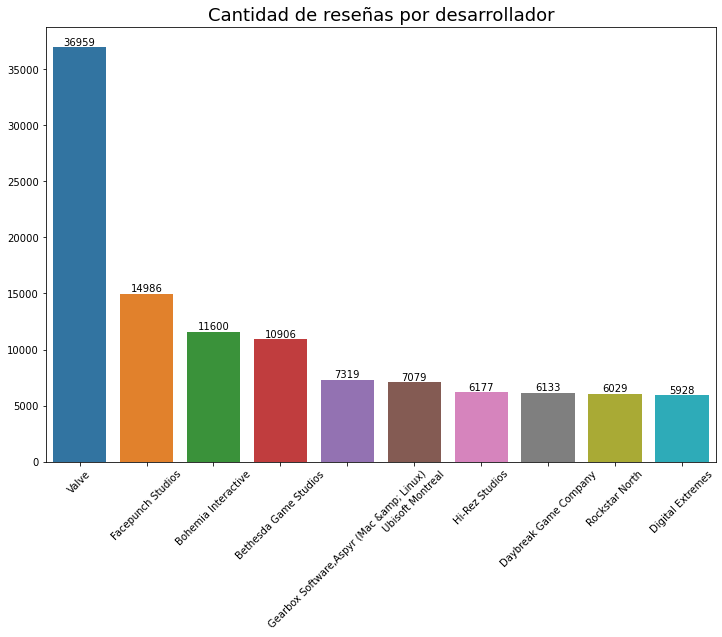

In [14]:
plt.figure(figsize=(12,8))
grafico1 = sns.countplot(x = "developer", data = data, order = data["developer"].value_counts().iloc[:10].index)
plt.title("Cantidad de reseñas por desarrollador", fontsize=18)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("")

conteo = list(data.developer.value_counts())
for rect, label in zip(grafico1.patches, conteo):
    height = rect.get_height()
    grafico1.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

Nuevamente **Valve lidera en cantidad de reseñas pero en este caso como desarrollador**.

La distribucion de reseñas de acuerdo al género del juego es la siguiente:

In [15]:
data["genres"] = data["genres"].str.replace("]", "")
data["genres"] = data["genres"].str.replace("[", "")
data["genres"] = data["genres"].str.replace("'", "")
dummies = data["genres"].str.get_dummies(sep=",")
data = pd.concat([data, dummies], axis=1)
data = data.drop(["genres"], axis=1)

In [16]:
data["Action"]=data["Action"]+data[" Action"]
data = data.drop([" Action"], axis=1)

data["Adventure"]=data["Adventure"]+data[" Adventure"]
data = data.drop([" Adventure"], axis=1)

data["Audio Production"]=data[" Audio Production"]
data = data.drop([" Audio Production"], axis=1)

data["Casual"]=data["Casual"]+data[" Casual"]
data = data.drop([" Casual"], axis=1)

data["Design &amp; Illustration"]=data["Design &amp; Illustration"]+data[" Design &amp; Illustration"]
data = data.drop([" Design &amp; Illustration"], axis=1)

data["Early Access"]=data["Early Access"]+data[" Early Access"]
data = data.drop([" Early Access"], axis=1)

data["Education"]=data["Education"]+data[" Education"]
data = data.drop([" Education"], axis=1)

data["Free to Play"]=data["Free to Play"]+data[" Free to Play"]
data = data.drop([" Free to Play"], axis=1)

data["Indie"]=data["Indie"]+data[" Indie"]
data = data.drop([" Indie"], axis=1)

data["Massively Multiplayer"]=data["Massively Multiplayer"]+data[" Massively Multiplayer"]
data = data.drop([" Massively Multiplayer"], axis=1)

data["Photo Editing"]=data["Photo Editing"]+data[" Photo Editing"]
data = data.drop([" Photo Editing"], axis=1)

data["RPG"]=data["RPG"]+data[" RPG"]
data = data.drop([" RPG"], axis=1)

data["Racing"]=data["Racing"]+data[" Racing"]
data = data.drop([" Racing"], axis=1)

data["Simulation"]=data["Simulation"]+data[" Simulation"]
data = data.drop([" Simulation"], axis=1)

data["Software Training"]=data["Software Training"]+data[" Software Training"]
data = data.drop([" Software Training"], axis=1)

data["Sports"]=data["Sports"]+data[" Sports"]
data = data.drop([" Sports"], axis=1)

data["Strategy"]=data["Strategy"]+data[" Strategy"]
data = data.drop([" Strategy"], axis=1)

data["Utilities"]=data["Utilities"]+data[" Utilities"]
data = data.drop([" Utilities"], axis=1)

data["Video Production"]=data["Video Production"]+data[" Video Production"]
data = data.drop([" Video Production"], axis=1)

data["Web Publishing"]=data["Web Publishing"]+data[" Web Publishing"]
data = data.drop([" Web Publishing"], axis=1)

In [23]:
sumas = data.drop(["username", "app_name", "hours", "price", "publisher", "developer"], axis=1).sum(axis=0)
sumas = pd.DataFrame(sumas, columns = ["Total"])
sumas.index.name = "Generos"
sumas['Generos'] = sumas.index
sumas = sumas.sort_values(by=['Total'], ascending=False)

In [24]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

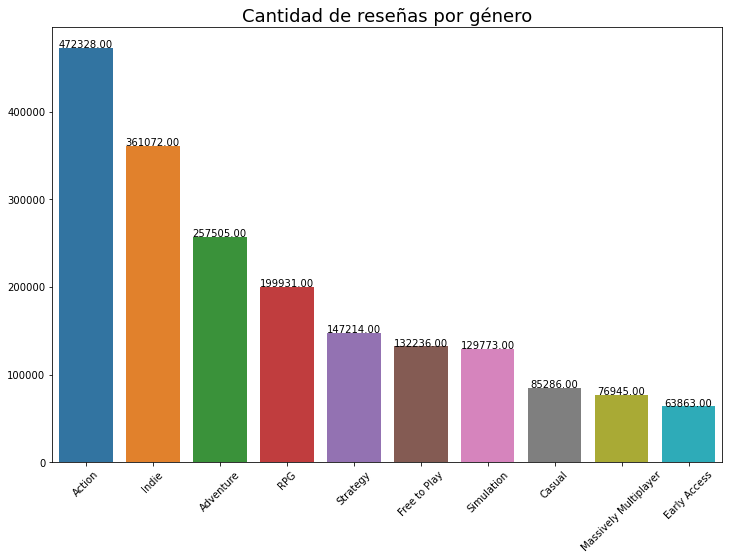

In [25]:
plt.figure(figsize=(12,8))
grafico = sns.barplot(x = "Generos", y = "Total", data = sumas[:10])
plt.title("Cantidad de reseñas por género", fontsize=18)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("")

show_values_on_bars(grafico)

plt.show()

Los **juegos de acción son los más populares** seguidos por aquellos clasificados como indie, aventura y Rol.

La cantidad de horas jugadas tiene la siguiente distribución (cabe destacar que se excluyeron valores atípicos para visualizar mejor la distribución):

<Figure size 864x576 with 0 Axes>

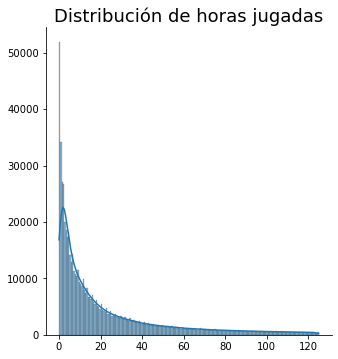

In [21]:
plt.figure(figsize=(12,8))
grafico = sns.displot(x = data.hours[data.hours<125], kde=True)
plt.title("Distribución de horas jugadas", fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.show()

La variable precio se distribuye de la siguiente manera:

<Figure size 864x576 with 0 Axes>

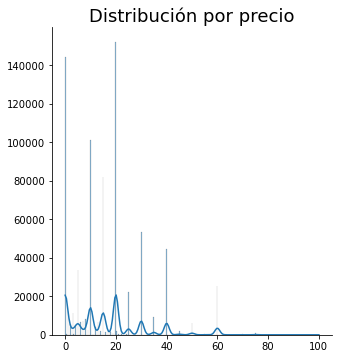

In [22]:
plt.figure(figsize=(12,8))
grafico = sns.displot(x = data.price[data.price<100], kde=True)
plt.title("Distribución por precio", fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.show()

# 2. Modelo de recomendación

Se va a trabajar con un **sistema de recomendación colaborativo**, es decir que se trata de un sistema que va a recomendar a usuarios juegos de acuerdo a los gustos de otras personas similares. En este caso **si bien no contamos con una puntuación otorgada si contamos con la variable de horas jugadas que funciona como buen proxy**.

La principal ventaja que tienen este tipo de sistemas es que **no necesitan conocer nada de los items** (en este caso juegos) dado que las recomendaciones son realizadas en base a la similitud entre los usuarios. Las contras de este enfoque son:
1. Encuentra dificultades a la hora de recomendar nuevos items o items que no hayan sido probados por muchos usuarios.
2. Problemas generados cuando la base de datos es muy extensa y se genera una escasez de datos.

Para limitar el segundo problema se van a eliminar los juegos que hayan sido jugados por menos de 1.000 usuarios:


In [36]:
data_nueva = data[data.groupby("app_name")["app_name"].transform('size') > 999]
data_nueva.shape

(304928, 7)

In [37]:
print("La cantidad de juegos del dataset original es: " + str(data["app_name"].nunique()))
print("La cantidad de juegos del dataset nuevo es: " + str(data_nueva["app_name"].nunique()))

La cantidad de juegos del dataset original es: 12070
La cantidad de juegos del dataset nuevo es: 138


Es decir que **se pasa de un dataset con 760.492 reseñas a uno con 304.928 y la cantidad de juegos se reduce a 138**.

Para estimar los modelos se va a utilizar la librería surprise para la cual es necesario utilizar el método Reader para importar los datos. El mismo requiere que se le asigne el valor mínimo y máximo del rating, en este caso de horas que funciona como proxy de rating:

In [38]:
data_nueva[["hours"]] = StandardScaler().fit_transform(data_nueva[["hours"]])

<ipython-input-38-0f4b7e8b7e53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nueva[["hours"]] = StandardScaler().fit_transform(data_nueva[["hours"]])
C:\Users\Javier Giordano\miniconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [39]:
minimo = data_nueva["hours"].min()
maximo = data_nueva["hours"].max()
print("El valor mínimo es {0}, mientras que el valor máximo es {1}" .format(minimo, maximo))

El valor mínimo es -0.39455067221620166, mientras que el valor máximo es 38.679348178822


In [40]:
reader = Reader(rating_scale = (minimo, maximo))
datas = Dataset.load_from_df(data_nueva[['username', 'app_name', 'hours']], reader)

Para determinar con que modelo continuar se procede a hacer una validacion cruzada utilizando distintos algoritmos siendo la **raíz del error cuadratico medio (RMSE) la medida utilizada para determinar con que modelo seguir**.

In [41]:
benchmark = []
for algorithm in [NormalPredictor(), BaselineOnly(), SVD(), SVDpp(), CoClustering()]:
    results = cross_validate(algorithm, datas, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.905786,20.775499,1.111849
BaselineOnly,0.911609,1.254734,1.192926
NormalPredictor,1.250474,0.538148,1.350828
CoClustering,1.421648,37.680518,0.884786
SVDpp,13.522501,41.711780,1.642059


De acuerdo a lo obtenido **el modelo SVD es el que arroja el menor RMSE y por ende el seleccionado para optimizar el número de factores**.



In [42]:
rmse_test_means = []
factores = [1,2,3,4,5,6,7,8,9,10,15,20,50]

for factor in factores:
    print(factor)
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, datas, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9220  0.9012  0.9102  0.9111  0.0086  
Fit time          4.29    4.26    4.30    4.28    0.01    
Test time         0.94    1.11    0.83    0.96    0.12    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9182  0.8982  0.9093  0.9086  0.0082  
Fit time          4.46    4.39    4.40    4.42    0.03    
Test time         0.85    1.09    1.09    1.01    0.12    
3
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8903  0.9285  0.9150  0.9113  0.0158  
Fit time          5.44    5.08    4.86    5.13    0.24    
Test time         0.96    1.32    0.99    1.09    0.16    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8878  0.9

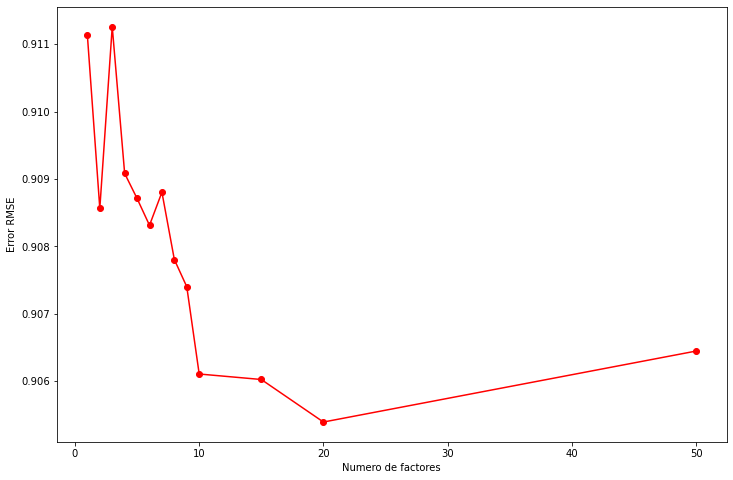

In [43]:
plt.figure(figsize=(12,8))
plt.plot(factores, rmse_test_means, 'o-', color="r", label="Training score")
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

**El número óptimo de factores es 20 dado que es el que minimiza el RMSE**. 

A continuación se va a mostrar el algoritmo predictivo en acción:

In [68]:
trainset, testset = train_test_split(datas, test_size=.25)

SVD = SVD(n_factors=20)

SVD.fit(trainset)

In [69]:
predictions = SVD.test(testset)

En el ejemplo se le recomendaran juegos al usuario Tom. Para ello se comienza haciendo un listado de los juegos que ya jugó para no recomendarle los mismos:

In [70]:
lista_juegos = data_nueva['app_name'].unique()
lista_juegos_jugados_Tom = data_nueva.loc[data_nueva["username"] == "Tom","app_name"]
lista_juegos_predecir_Tom = np.setdiff1d(lista_juegos,lista_juegos_jugados_Tom)

Se generan las predicciones:

In [72]:
recomendaciones_Tom = []
for app_name in lista_juegos_predecir_Tom:
    recomendaciones_Tom.append((app_name, SVD.predict(uid="Tom", iid=app_name).est))

In [75]:
pd.DataFrame(recomendaciones_Tom, columns=['Juegos', 'Predicciones']).sort_values('Predicciones', ascending=False).head(10)

,Juegos,Predicciones
7,Arma 3,1.100255
0,APB Reloaded,0.802342
53,Mount & Blade: Warband,0.514515
1,ARK: Survival Evolved,0.456268
62,Realm of the Mad God,0.255521
51,Magic Duels,0.204426
88,Total War™: ROME II - Emperor Edition,0.174184
40,Grim Dawn,0.162974
41,H1Z1,0.141621
60,PlanetSide 2,0.087267


Los tres juegos que el sistema recomienda a Tom son Arma 3, APB Reloaded y Mount & Blade.

# 3. Conclusiones

1. El mejor modelo de acuerdo a al criterio de RMSE fue el de SVD.
2. El número óptimo de factores fue de 20.

Limitaciones (u oportunidades de mejora):
1. No se pudo realizar uno optimización de hiperparámetros mediante Grid Search y/o Random Search dado que la misma resultó demasiado demandante en términos de poder de computo.
2. El problema de poder de computo también llevó a que fuese necesario reducir el dataset para que el cálculo no se volviera imposible.
3. El sistema de recomendación es puramente colaborativo con lo cual existe la posibilidad de incorporar conceptos de sistemas de recomendación por contenido.